In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input - 1 output 32 OUtput? RF
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(32, 32, 3)
        self.conv6 = nn.Conv2d(32, 32, 3)
        self.conv7 = nn.Conv2d(32, 10, 3)
        self.gap = nn.AvgPool2d(10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = F.relu(self.conv7(x))
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [7]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 32, 28, 28]           9,248
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
            Conv2d-5           [-1, 32, 14, 14]           9,248
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 32, 5, 5]           9,248
            Conv2d-8             [-1, 32, 3, 3]           9,248
            Conv2d-9             [-1, 10, 1, 1]           2,890
Total params: 49,450
Trainable params: 49,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.55
Params size (MB): 0.19
Estimated Total Size (MB): 0.74
---------------------------------------------

<ipython-input-6-52c7d8d07908>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [ ]:
classes = range(10)

tensor(-0.4242)
tensor(2.8215)
tensor(0.0124)
tensor(1.0131)
9


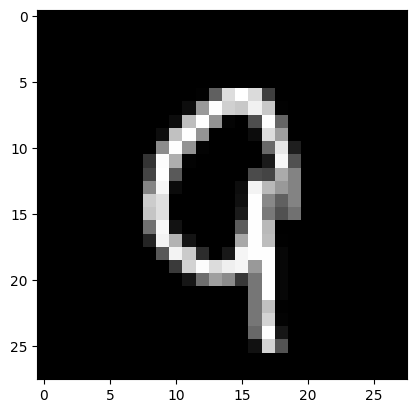

In [ ]:
# sanity check for training data
imgs, lbls = next(iter(train_loader))
imgs[7].data.shape
print(imgs.data.min())
print(imgs.data.max())
print(imgs.data.mean())
print(imgs.data.std())
print(classes[lbls[0]])
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 10):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-3-c017d5d3b8dd>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=1.1991945505142212 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 23.60it/s]



Test set: Average loss: 1.2448, Accuracy: 4783/10000 (48%)



loss=1.0794168710708618 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s]



Test set: Average loss: 0.7804, Accuracy: 6787/10000 (68%)



loss=0.565229058265686 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]



Test set: Average loss: 0.5383, Accuracy: 7752/10000 (78%)



loss=0.2215334177017212 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 24.25it/s]



Test set: Average loss: 0.2970, Accuracy: 8763/10000 (88%)



loss=0.24600695073604584 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 23.50it/s]



Test set: Average loss: 0.2957, Accuracy: 8767/10000 (88%)



loss=0.10898052901029587 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]



Test set: Average loss: 0.2910, Accuracy: 8770/10000 (88%)



loss=0.4565449655056 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]



Test set: Average loss: 0.2913, Accuracy: 8780/10000 (88%)



loss=0.26663607358932495 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]



Test set: Average loss: 0.2890, Accuracy: 8780/10000 (88%)



loss=0.2207171767950058 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 24.09it/s]



Test set: Average loss: 0.2943, Accuracy: 8775/10000 (88%)

